In [1]:
%matplotlib inline

import pandas as pd
import os
import sys
import glob
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import datetime
import math
from scipy import sparse
import random

import scanpy as sc
import scvelo as scv
import cellrank as cr

# settings
plt.rc('font', size = 9)
plt.rc('font', family='sans serif')
plt.rcParams['pdf.fonttype']=42
plt.rcParams['ps.fonttype']=42
plt.rcParams['text.usetex']=False
plt.rcParams['legend.frameon']=False
plt.rcParams['axes.grid']=False
plt.rcParams['legend.markerscale']=0.5
sc.set_figure_params(dpi=300,dpi_save=600,
                     frameon=False,
                     fontsize=9)
plt.rcParams['savefig.dpi']=600
sc.settings.verbosity=2
sc._settings.ScanpyConfig.n_jobs=-1
sns.set_style("ticks")



In [2]:

fpath = '/home/ngr4/scratch60/scnd/data/processed/'
adata = sc.read(os.path.join(fpath, 'adata_and_loom_2110514.h5ad'))


In [3]:
adata = adata[(adata.obs['ctype']=='Astrocyte') & (adata.obs['genotype']=='WT'), :]


In [4]:
adata

View of AnnData object with n_obs × n_vars = 4078 × 26374
    obs: 'batch', 'genotype', 'timepoint', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pmito', 'n_genes', 'louvain', 'res_sca1', 'ees_sca1', 'stored_ctype', 'ctype', 'sample_batch', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    uns: 'louvain', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_phate', 'X_umap'
    varm: 'PCs'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

# standard Cellrank recipe

In [5]:
# standard recipe for pancreas; REF: 
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=20, n_neighbors=30)
scv.pp.moments(adata, n_pcs=20, n_neighbors=30)

computing PCA
    with n_comps=50
    finished (0:00:16)
computing neighbors
    using 'X_pca' with n_pcs = 20
    finished (0:00:13)


Normalized count data: spliced, unspliced.
computing moments based on connectivities
    finished (0:00:03) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [6]:
scv.tl.recover_dynamics(adata)

recovering dynamics (using 1/20 cores)


  0%|          | 0/1212 [00:00<?, ?gene/s]

    finished (0:08:23) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


/gpfs/ycga/project/dijk/ngr4/conda_envs/monocle3/lib/python3.8/site-packages/scvelo/tools/dynamical_model.py:697: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.alpha, dm.beta, dm.gamma, dm.pars[:3]]) / dm.m[-1]
/gpfs/ycga/project/dijk/ngr4/conda_envs/monocle3/lib/python3.8/site-packages/scvelo/tools/dynamical_model.py:700: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.t, dm.tau, dm.t_, dm.pars[4]]) * dm.m[-1]


In [7]:
scv.tl.velocity(adata, mode='stochastic')
scv.tl.velocity_graph(adata)

computing velocities
    finished (0:00:08) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:07) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [8]:
# recalculate phate and umap
sc.tl.umap(adata)
sc.external.tl.phate(adata, gamma=0)

computing UMAP
    finished (0:00:13)
computing PHATE


Calculating PHATE...
  Running PHATE on 4078 observations and 26374 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 5.83 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.71 seconds.
    Calculating affinities...
    Calculated affinities in 0.99 seconds.
  Calculated graph and diffusion operator in 7.59 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 1.13 seconds.
    Calculating KMeans...
    Calculated KMeans in 14.45 seconds.
  Calculated landmark operator in 17.00 seconds.
  Calculating optimal t...
    Automatically selected t = 20
  Calculated optimal t in 1.81 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.53 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 5.05 seconds.
Calculated PHATE in 31.98 seconds.


    finished (0:00:34)


In [9]:
cmap_wt = {v:sns.cubehelix_palette(5, start=0.5, rot=-0.75)[i] for i,v in enumerate(['5wk', '12wk', '18wk', '24wk', '30wk'])}
cmap_mut = {v:sns.cubehelix_palette(5)[i] for i,v in enumerate(['5wk', '12wk', '18wk', '24wk', '30wk'])}

computing velocity embedding
    finished (0:00:01) --> added
    'velocity_phate', embedded velocity vectors (adata.obsm)


/gpfs/ycga/project/dijk/ngr4/conda_envs/monocle3/lib/python3.8/site-packages/scvelo/plotting/utils.py:115: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = pl.figure(None, figsize, dpi=dpi).gca(projection=projection)


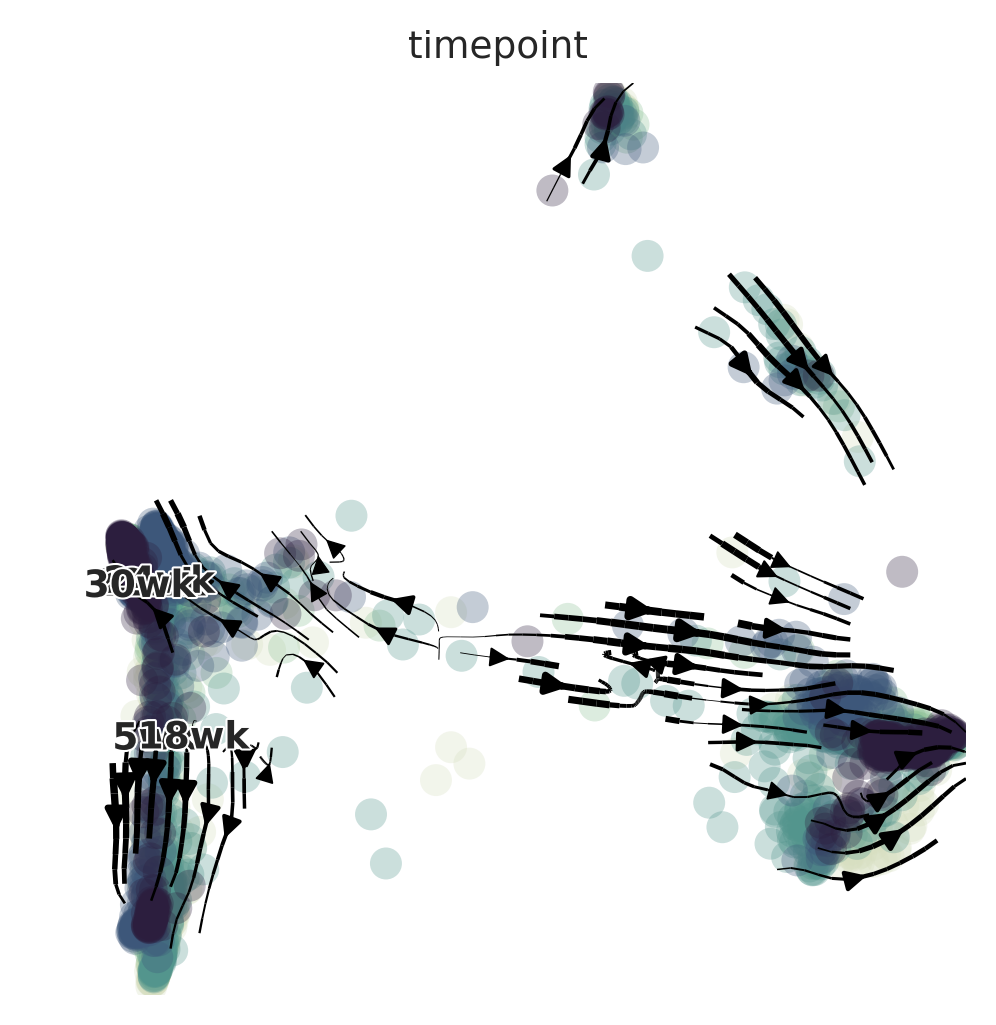

In [10]:
scv.pl.velocity_embedding_stream(adata, basis='phate', color=['timepoint',], palette=cmap_wt)


In [11]:
sc.tl.leiden(adata)

running Leiden clustering
    finished (0:00:00)


In [12]:
cr.tl.terminal_states(adata, clusters='leiden')

  0%|          | 0/4078 [00:00<?, ?cell/s]

  0%|          | 0/4078 [00:00<?, ?cell/s]

In [13]:
cr.tl.terminal_states(adata, clusters='leiden', estimator=cr.tl.estimators.CFLARE)


/gpfs/ycga/project/dijk/ngr4/conda_envs/monocle3/lib/python3.8/site-packages/scvelo/plotting/utils.py:115: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = pl.figure(None, figsize, dpi=dpi).gca(projection=projection)


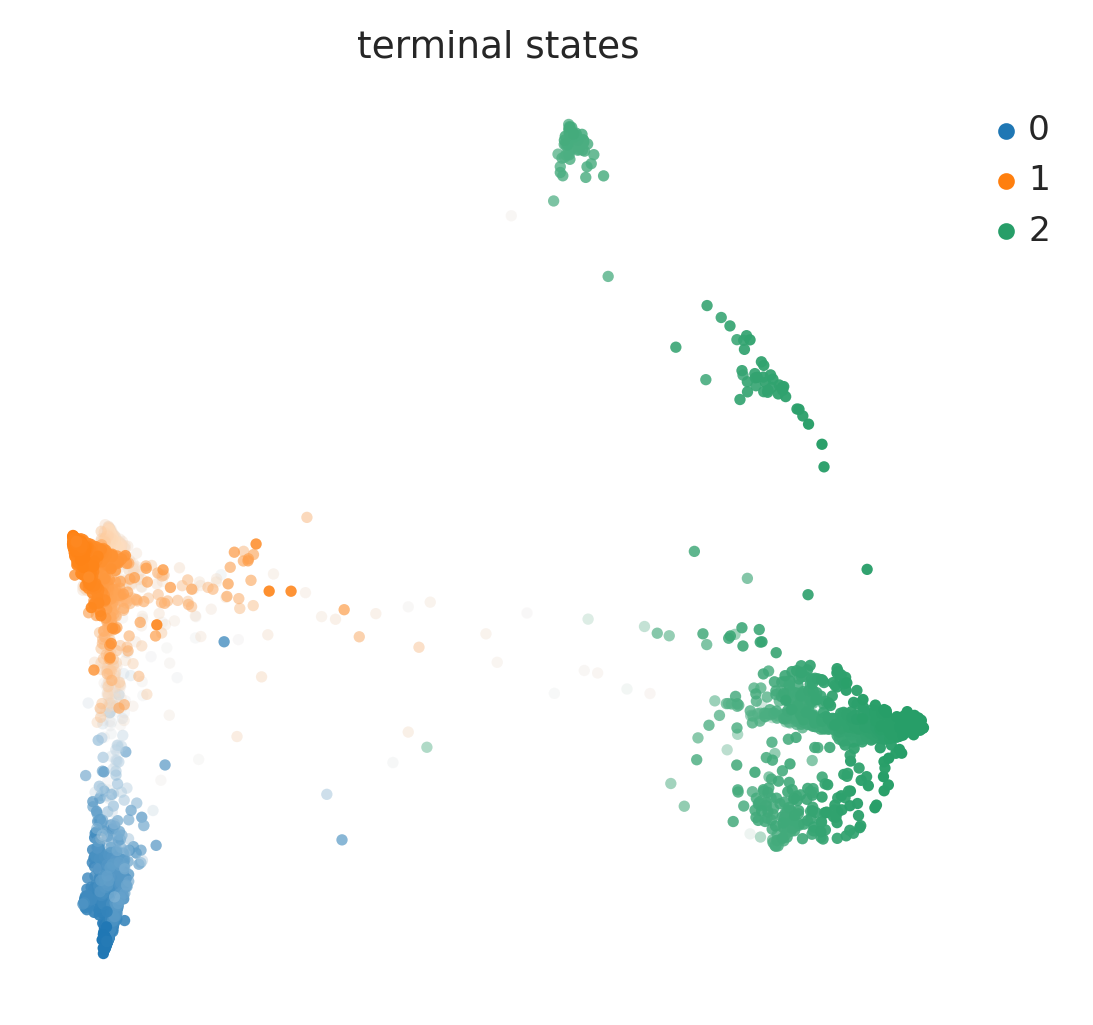

In [14]:
cr.pl.terminal_states(adata, basis='phate')


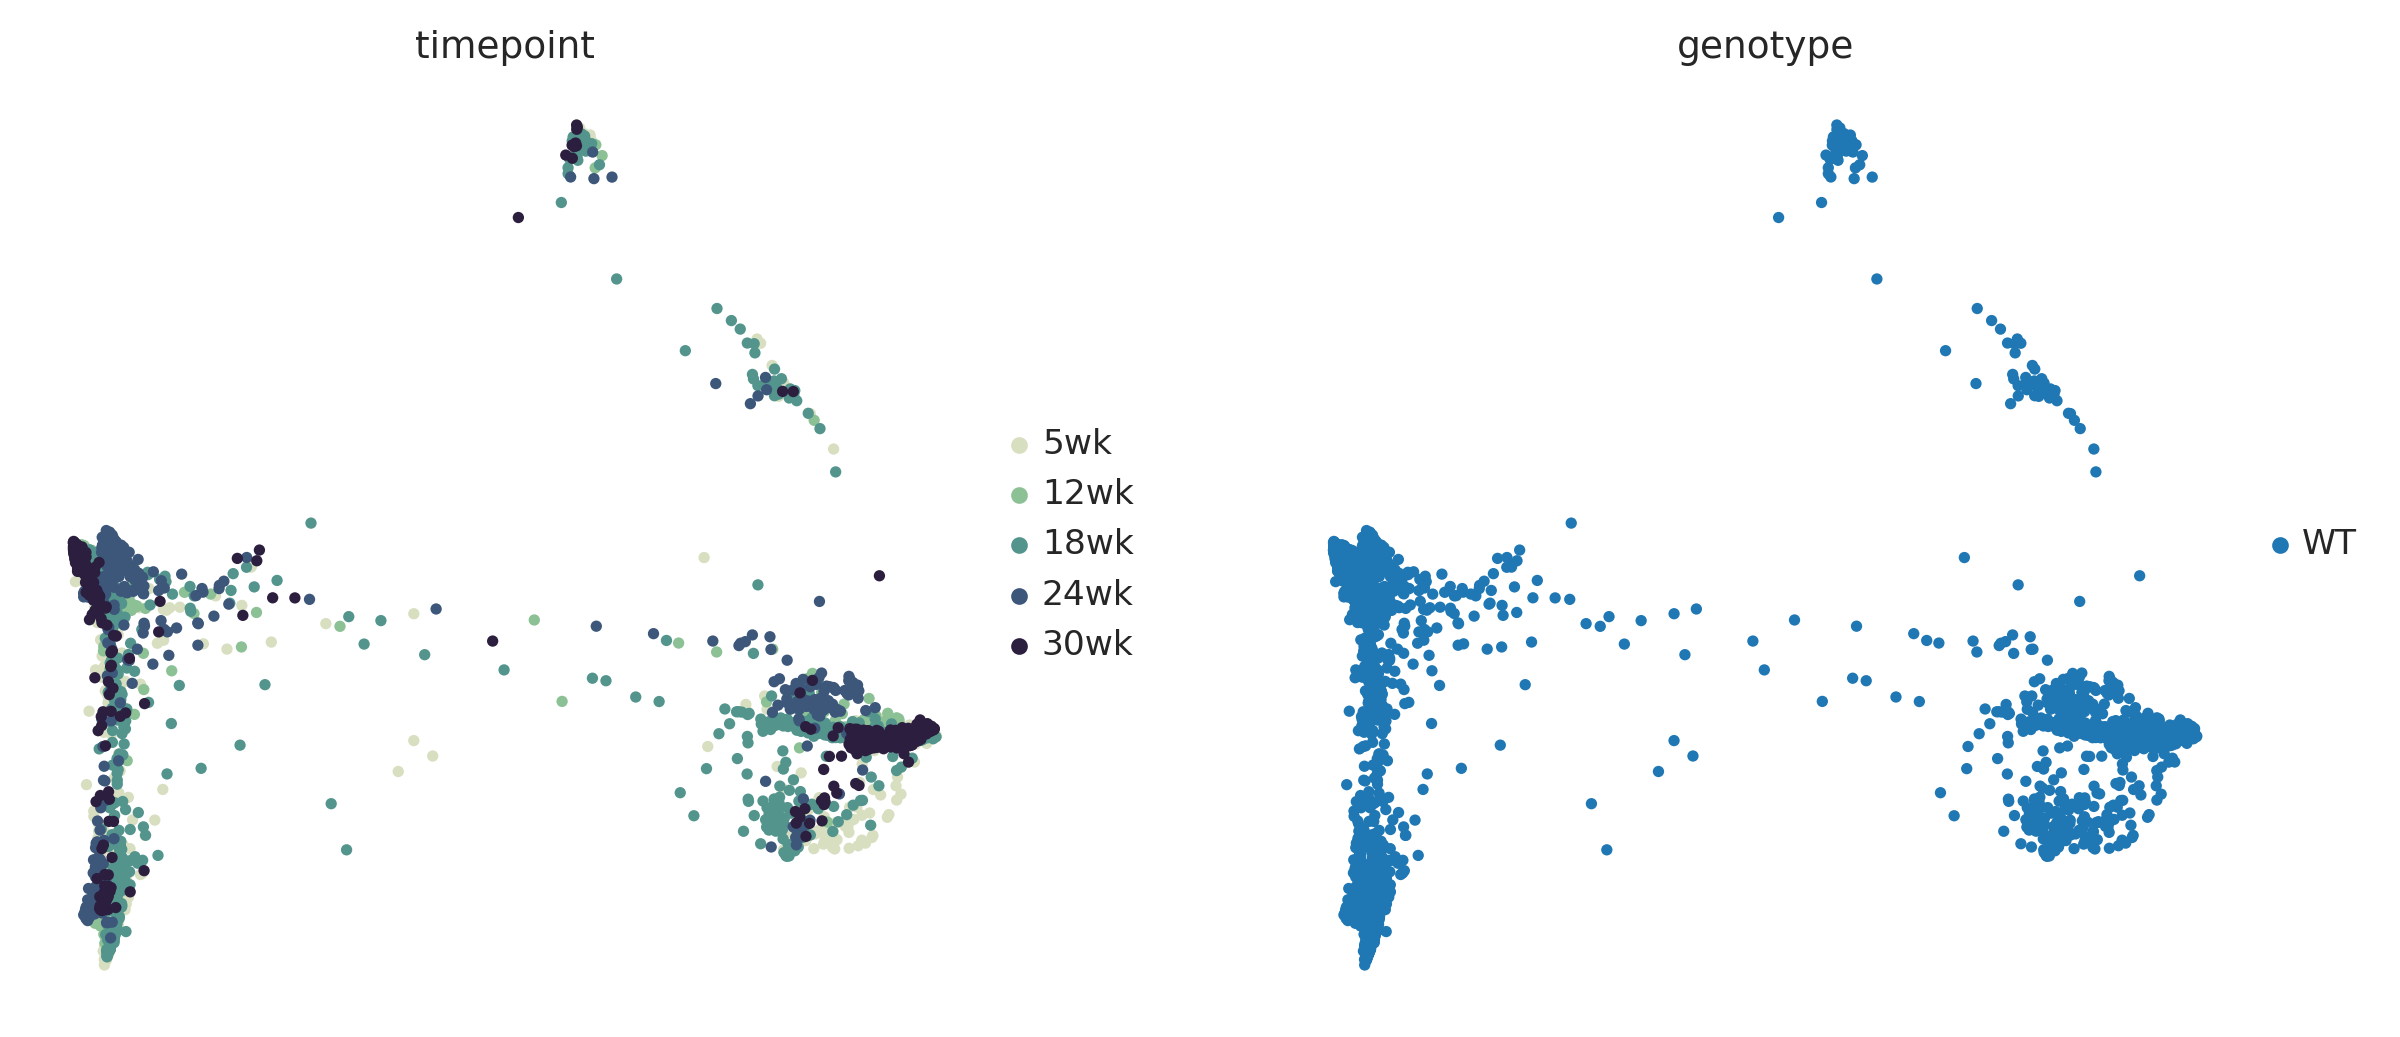

In [15]:
sc.external.pl.phate(adata, color=['timepoint', 'genotype'])

In [16]:
cr.tl.initial_states(adata, cluster_key='leiden')


  0%|          | 0/4078 [00:00<?, ?cell/s]

  0%|          | 0/4078 [00:00<?, ?cell/s]

/gpfs/ycga/project/dijk/ngr4/conda_envs/monocle3/lib/python3.8/site-packages/scvelo/plotting/utils.py:115: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = pl.figure(None, figsize, dpi=dpi).gca(projection=projection)


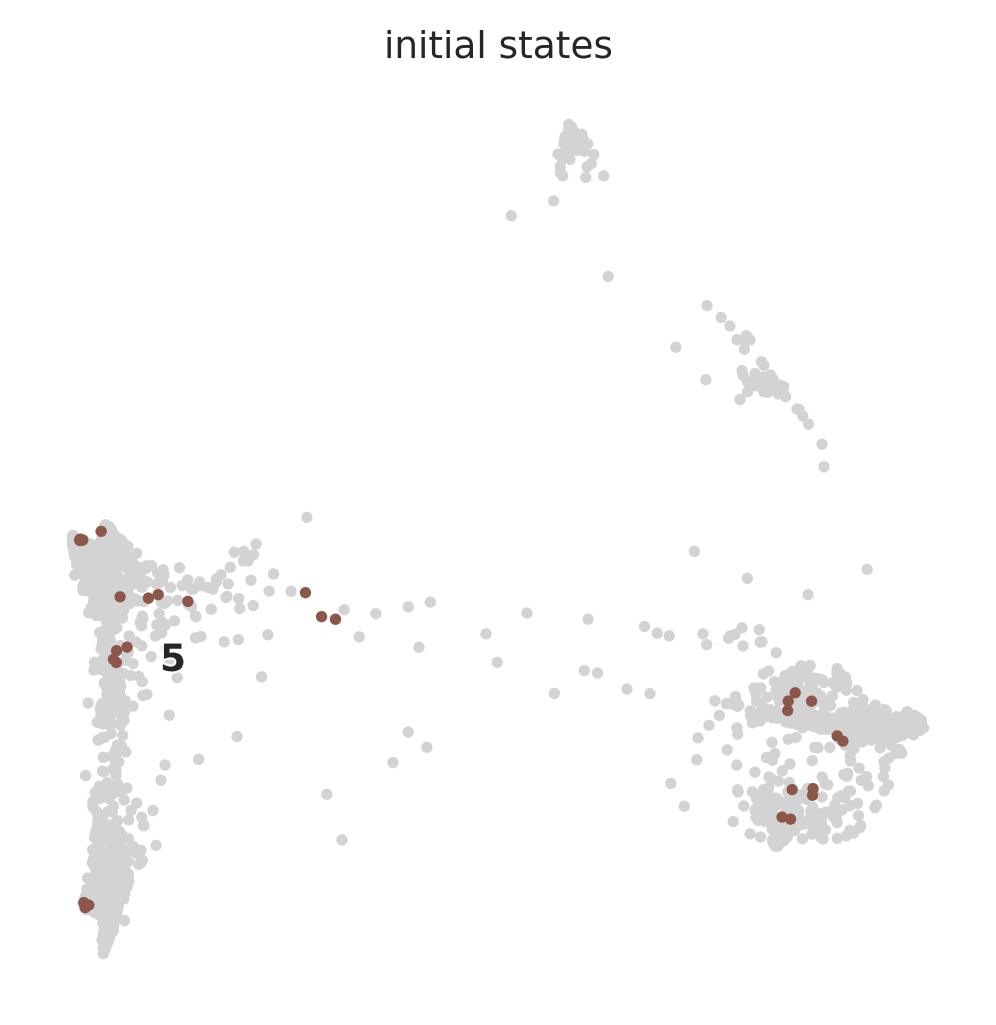

In [17]:
cr.pl.initial_states(adata, discrete=True, basis='phate')


  0%|          | 0/154 [00:00<?, ?/s]

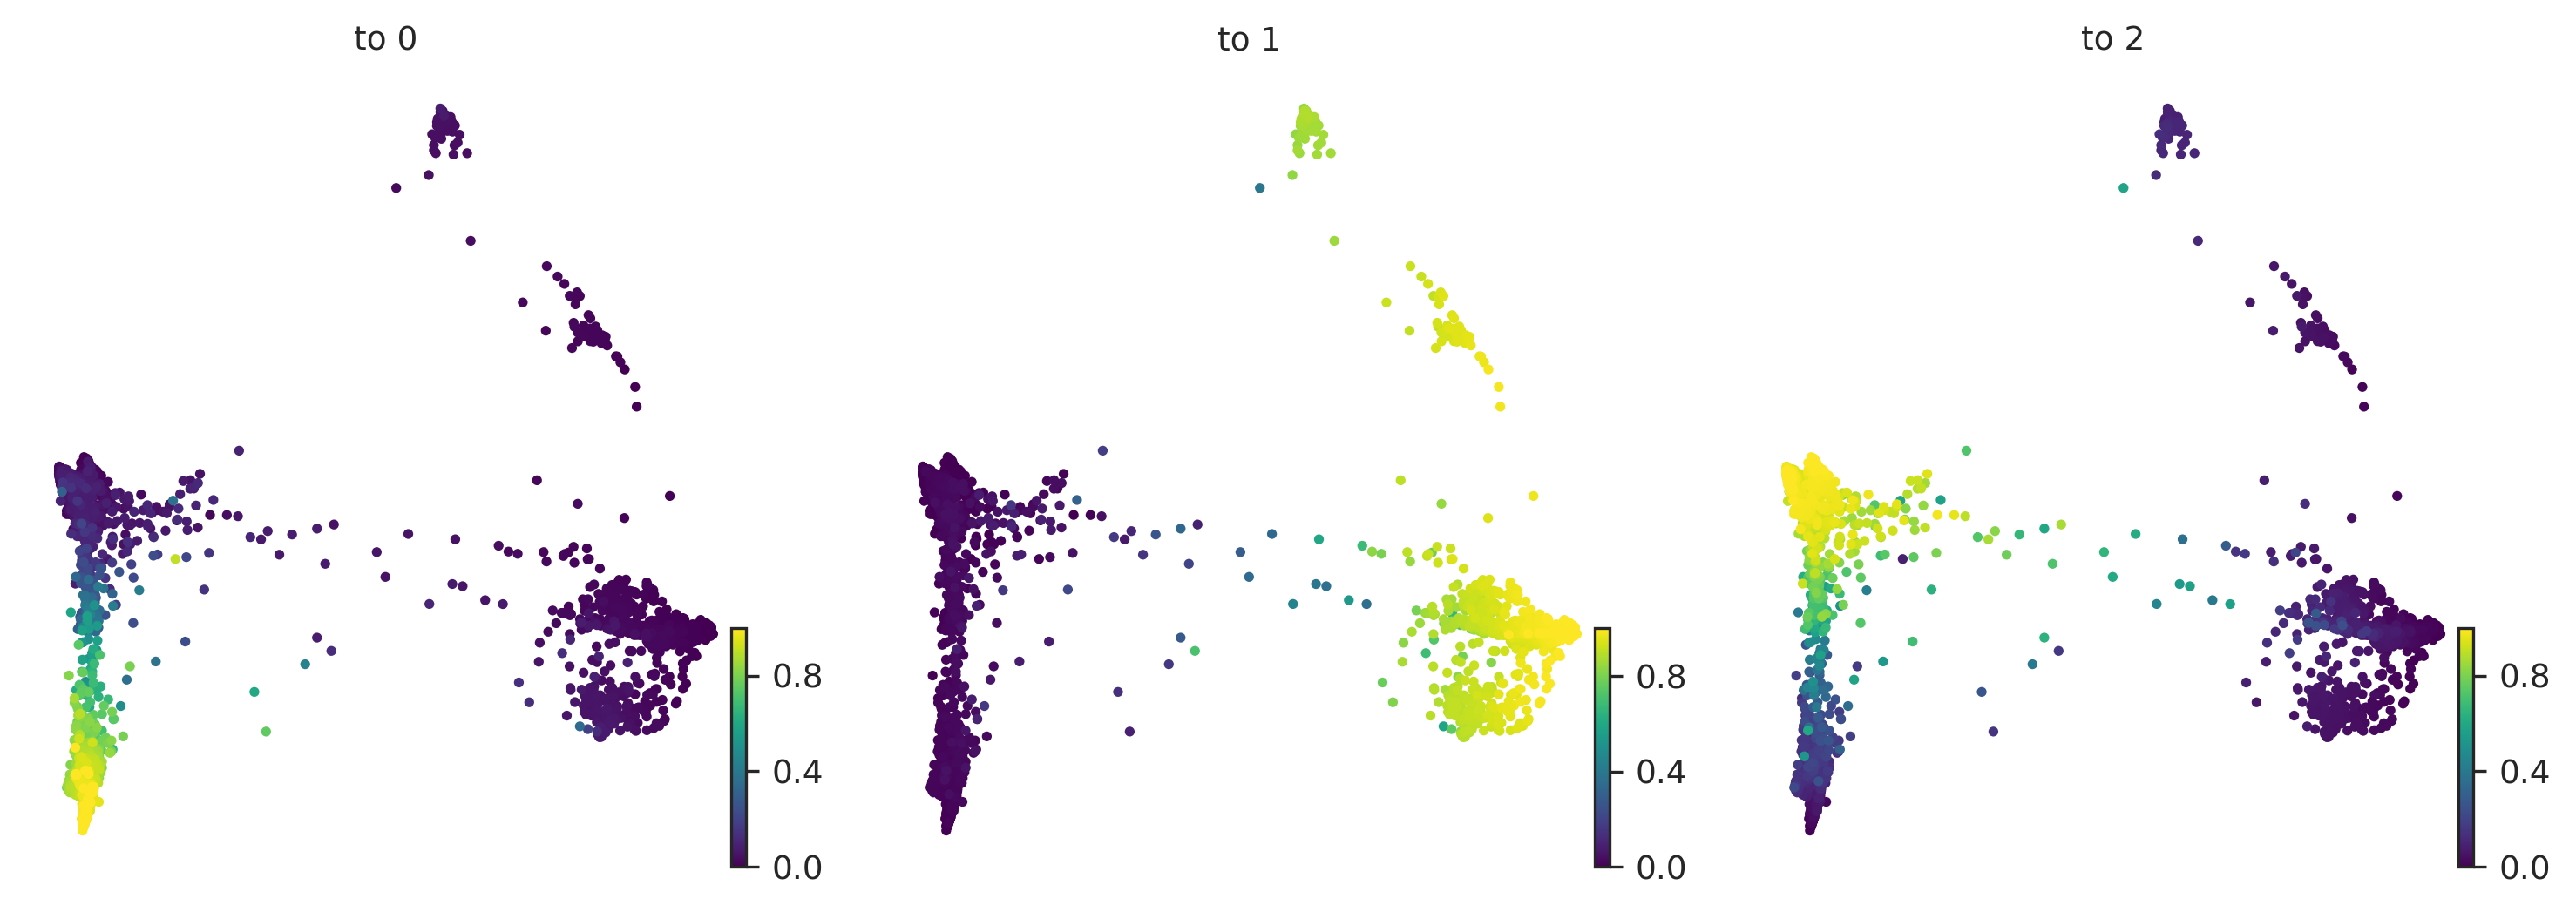

In [18]:
cr.tl.lineages(adata)
cr.pl.lineages(adata, same_plot=False, basis='phate')

/gpfs/ycga/project/dijk/ngr4/conda_envs/monocle3/lib/python3.8/site-packages/scvelo/plotting/utils.py:115: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = pl.figure(None, figsize, dpi=dpi).gca(projection=projection)


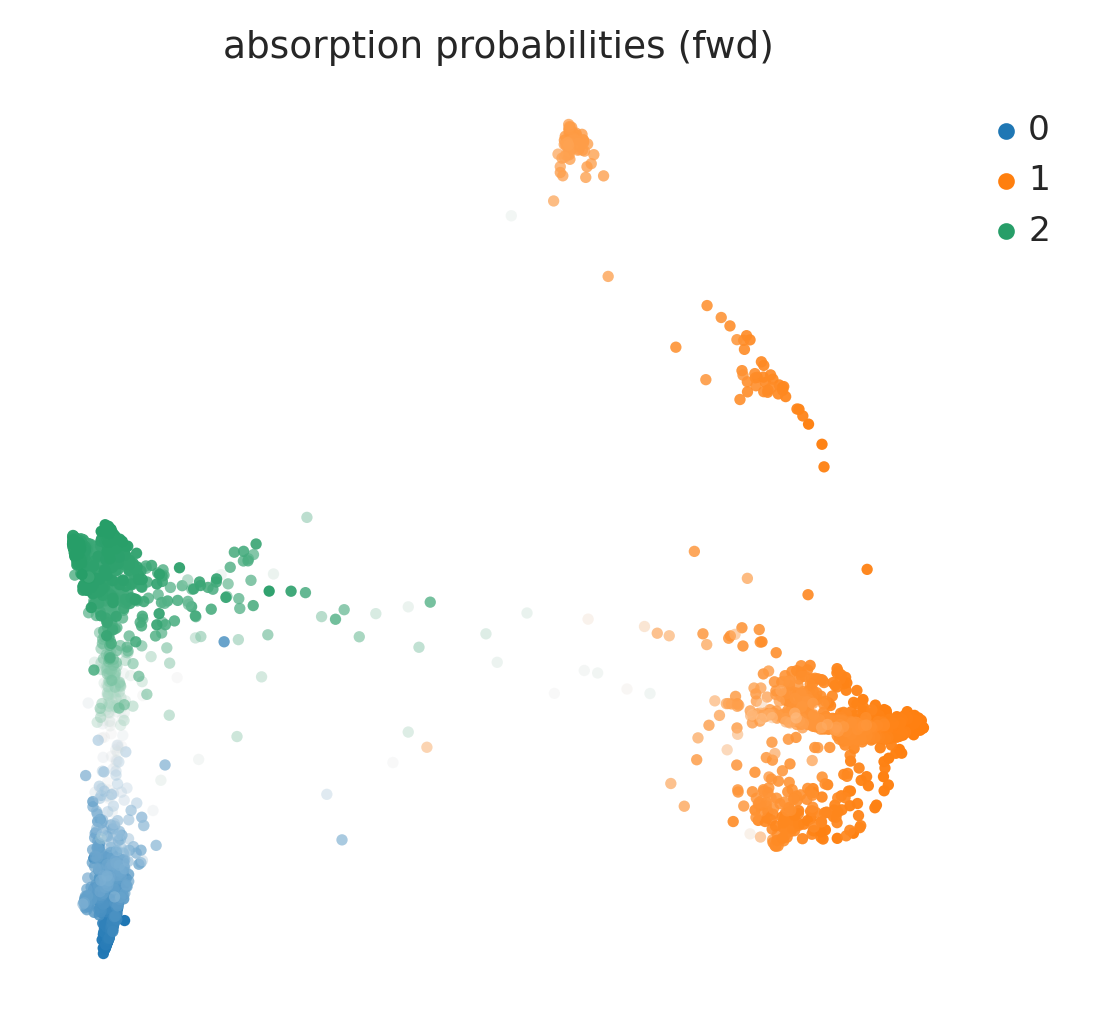

In [19]:
cr.pl.lineages(adata, same_plot=True, basis='phate')

In [20]:
# compute latent time
scv.tl.recover_latent_time(adata, root_key='initial_states_probs', end_key='terminal_states_probs')

computing latent time using initial_states_probs, terminal_states_probs as prior
    finished (0:00:02) --> added 
    'latent_time', shared time (adata.obs)


In [21]:
scv.tl.paga(adata, groups='leiden', root_key='initial_states_probs', end_key='terminal_states_probs',
            use_time_prior='velocity_pseudotime')

running PAGA using priors: ['velocity_pseudotime', 'initial_states_probs', 'terminal_states_probs']
    finished (0:00:01) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


In [46]:
import phate
adata.obsm['1dphate'] = phate.PHATE(gamma=0, n_components=1).fit_transform(adata.X)


In [23]:
rand_hgt = np.random.uniform(size=(data_phate1d.shape[0],))

In [28]:
adata.obs.columns

Index(['batch', 'genotype', 'timepoint', 'n_genes_by_counts',
       'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts',
       'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes',
       'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pmito',
       'n_genes', 'louvain', 'res_sca1', 'ees_sca1', 'stored_ctype', 'ctype',
       'sample_batch', 'initial_size_spliced', 'initial_size_unspliced',
       'initial_size', 'n_counts', 'velocity_self_transition', 'leiden',
       'terminal_states', 'terminal_states_probs', 'clusters_gradients',
       'initial_states', 'initial_states_probs', 'velocity_pseudotime',
       'latent_time'],
      dtype='object')

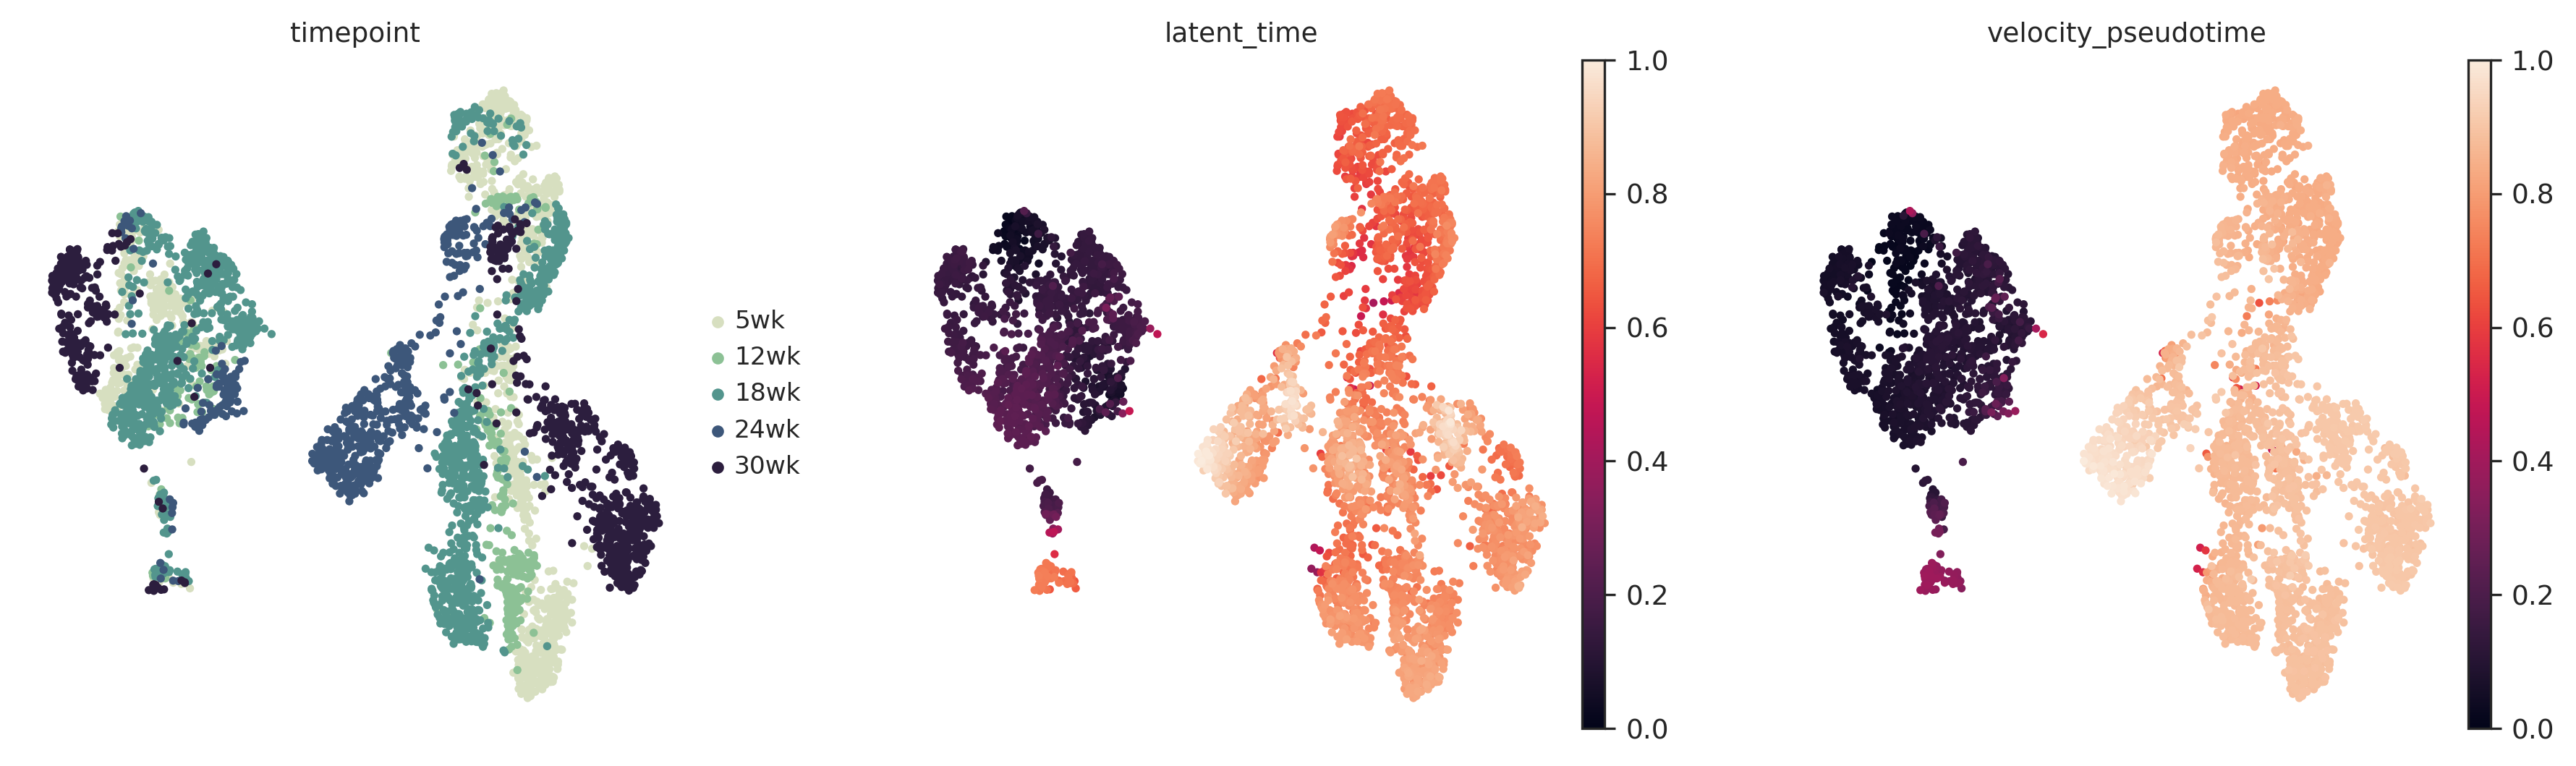

In [29]:
# make required plots
sc.pl.umap(adata, color=['timepoint', 'latent_time', 'velocity_pseudotime'])

In [49]:
# format data like monocle one
dt = pd.DataFrame()
dt['UMAP 1'] = adata.obsm['X_umap'][:, 0]
dt['UMAP 2'] = adata.obsm['X_umap'][:, 1]
dt['timepoint'] = adata.obs['timepoint'].to_list()
dt['Pseudotime'] = adata.obs['latent_time'].to_list()
dt['timepoint_int'] = [int(i.split('wk')[0]) for i in dt['timepoint']]


In [32]:
savefigs = True

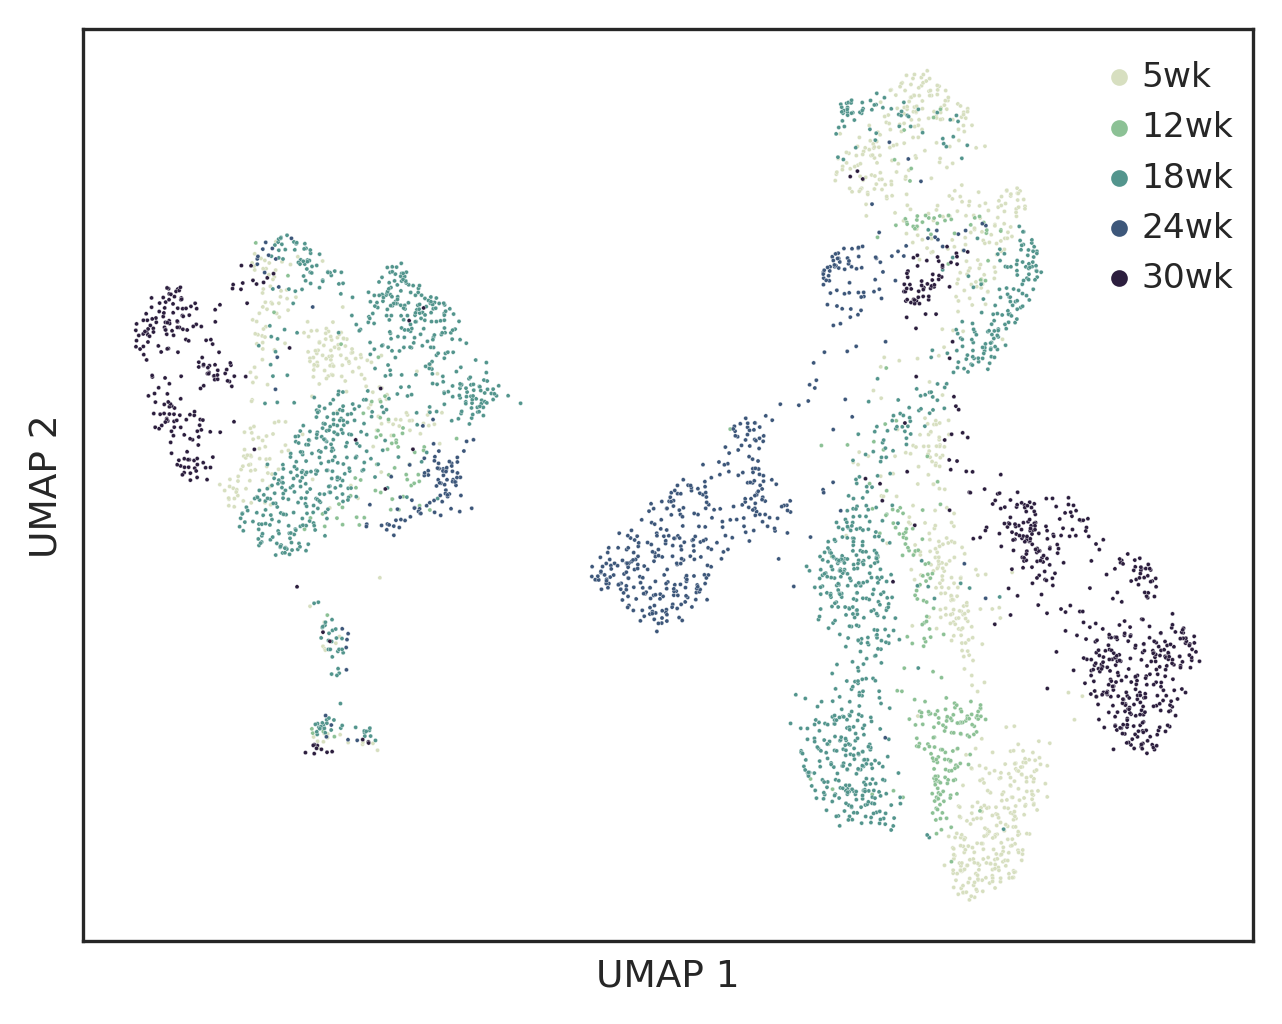

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
sns.scatterplot(dt['UMAP 1'], dt['UMAP 2'], hue=dt['timepoint'], palette=cmap_wt, s=1, rasterized=True, ax=ax)

ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('UMAP 1')
ax.legend(bbox_to_anchor=(1.01, 1))

if savefigs:
    fig.savefig('/home/ngr4/project/scnd/results/cellrank_umap_bytimepoint.pdf', bbox_inches='tight', dpi=600)
    savefigs = False

In [41]:
savefigs = True

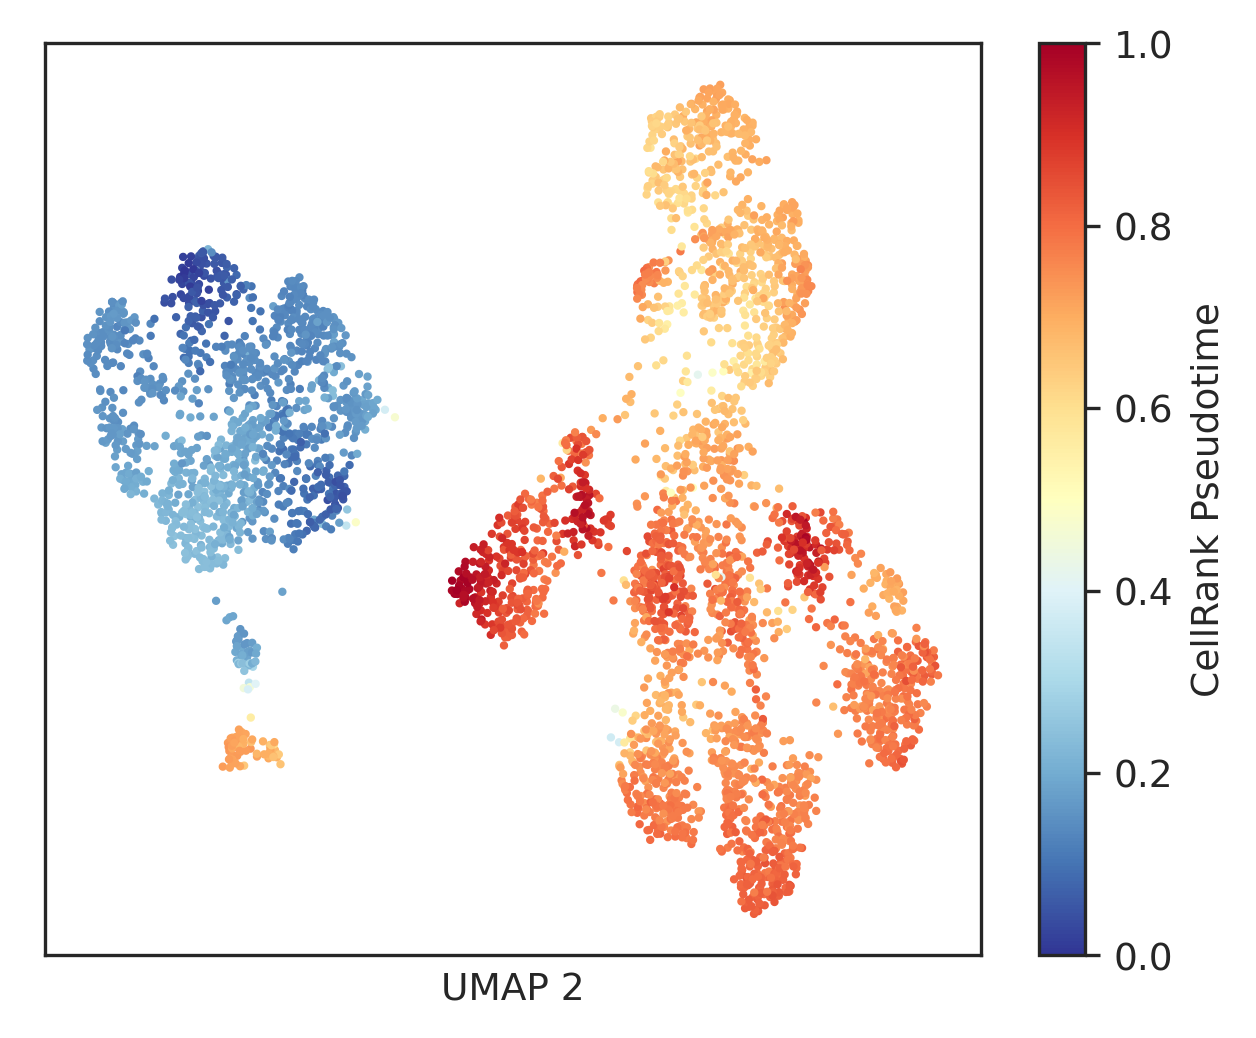

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
im = ax.scatter(dt['UMAP 1'], dt['UMAP 2'], c=dt['Pseudotime'], cmap='RdYlBu_r', s=1, rasterized=True)

ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('UMAP 1')
ax.set_xlabel('UMAP 2')
cbar = fig.colorbar(im)
cbar.set_label('CellRank Pseudotime', rotation=90)
if savefigs:
    fig.savefig('/home/ngr4/project/scnd/results/cellrank_umap_bypseudot.pdf', bbox_inches='tight', dpi=600)
    savefigs = False

In [43]:
from scipy.stats import pearsonr
from scipy.stats import kendalltau

In [52]:
savefigs = True
pfp = '/home/ngr4/project/scnd/results/'

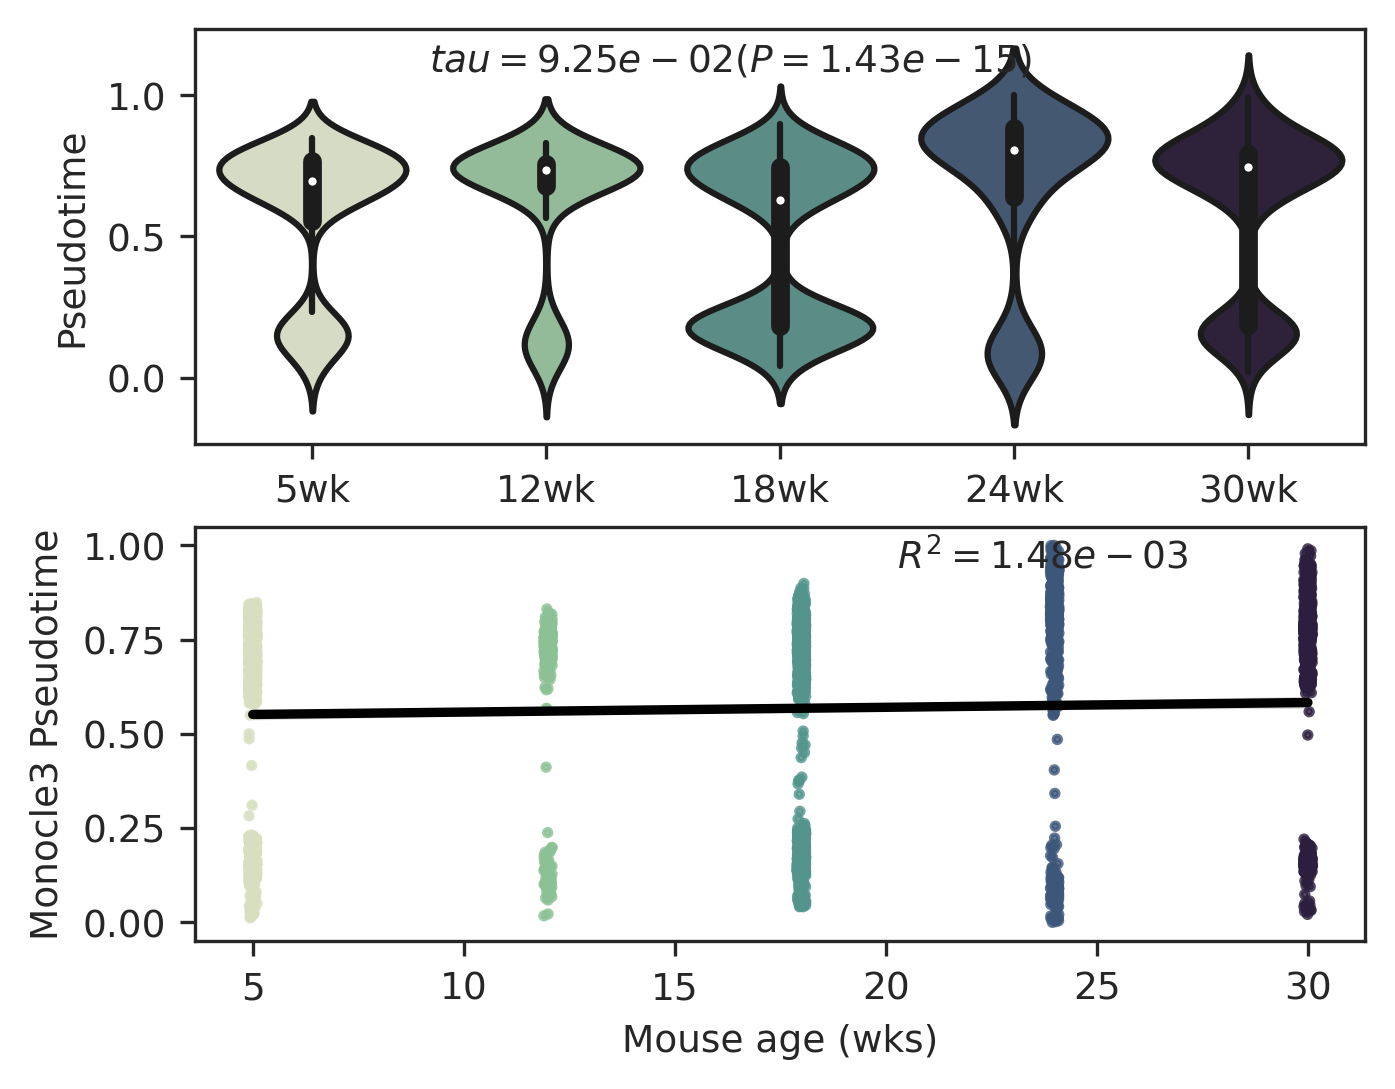

In [53]:
fig, ax = plt.subplots(2, 1, figsize=(5, 4))
sns.violinplot(x='timepoint', y='Pseudotime', ax=ax[0], data=dt, dodge=False, hue='timepoint', palette=cmap_wt)
ax[0].set_xlabel('')
ax[0].legend().set_visible(False)
sns.regplot(x='timepoint_int', y='Pseudotime', data=dt, ax=ax[1], scatter=False, color='k')
ax[1].scatter(dt['timepoint_int']+np.random.uniform(-0.1, 0.1, size=(dt.shape[0], )),
           dt['Pseudotime'], 
           c=dt['timepoint'].map(cmap_wt), s=3, alpha=0.8, rasterized=True)
r, p_pearson = pearsonr(dt['timepoint_int'], dt['Pseudotime'])
tau, p_kendall = kendalltau(dt['timepoint_int'], dt['Pseudotime'])
R2 = r**2
ax[0].text(0.2, 0.9, '$tau={:.2e} (P={:.2e})$'.format(tau, p_kendall), transform=ax[0].transAxes, weight='bold',)
ax[1].text(0.6, 0.9, '$R^2={:.2e}$'.format(R2), transform=ax[1].transAxes, weight='bold',)
ax[1].set_ylabel('Monocle3 Pseudotime')
ax[1].set_xlabel('Mouse age (wks)')

if savefigs:
    fig.savefig(os.path.join(pfp, 'violin_scatterplot_cellrankpseudotVtimepoint.pdf'), dpi=600, bbox_inches='tight')
    savefigs = False

In [54]:
savefigs = True

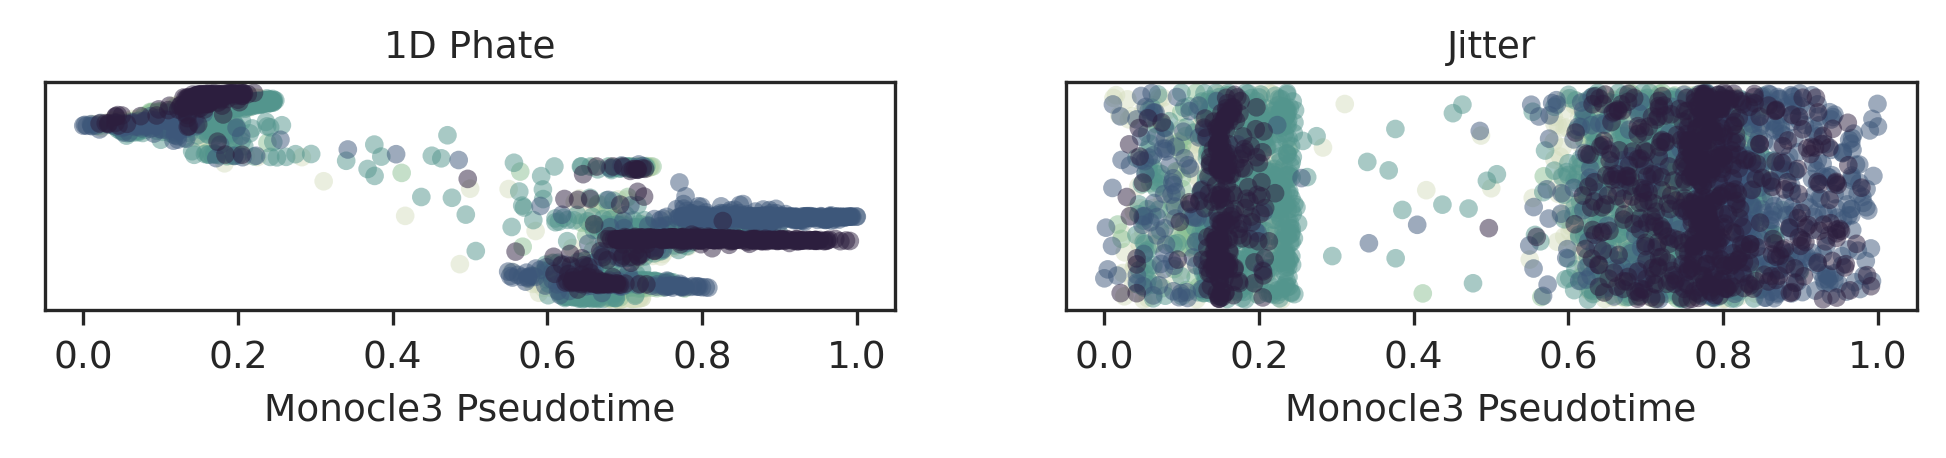

In [55]:
fig, ax = plt.subplots(1, 2, figsize=(8,1))
sns.scatterplot(x=dt['Pseudotime'], y=adata.obsm['1dphate'].squeeze(), hue=adata.obs['timepoint'].to_list(), palette=cmap_wt,
                s=20, alpha=0.5, linewidth=0, ax=ax[0], rasterized=True)
ax[0].set_xlabel('Monocle3 Pseudotime')
ax[0].set_yticks([])
ax[0].legend().set_visible(False)
ax[0].set_title('1D Phate')

sns.scatterplot(x=dt['Pseudotime'], y=np.random.uniform(-1, 1, size=(dt.shape[0],)), hue=adata.obs['timepoint'].to_list(), palette=cmap_wt,
                s=20, alpha=0.5, linewidth=0, ax=ax[1], rasterized=True)
ax[1].set_xlabel('Monocle3 Pseudotime')
ax[1].set_yticks([])
ax[1].legend().set_visible(False)
ax[1].set_title('Jitter')

if savefigs:
    fig.savefig(os.path.join(pfp, 'scatterplots_phateVcellrankpseudot.pdf'), dpi=600, bbox_inches='tight')
    savefigs = False

Text(0.5, 1.0, 'Cellrank pseudotime')

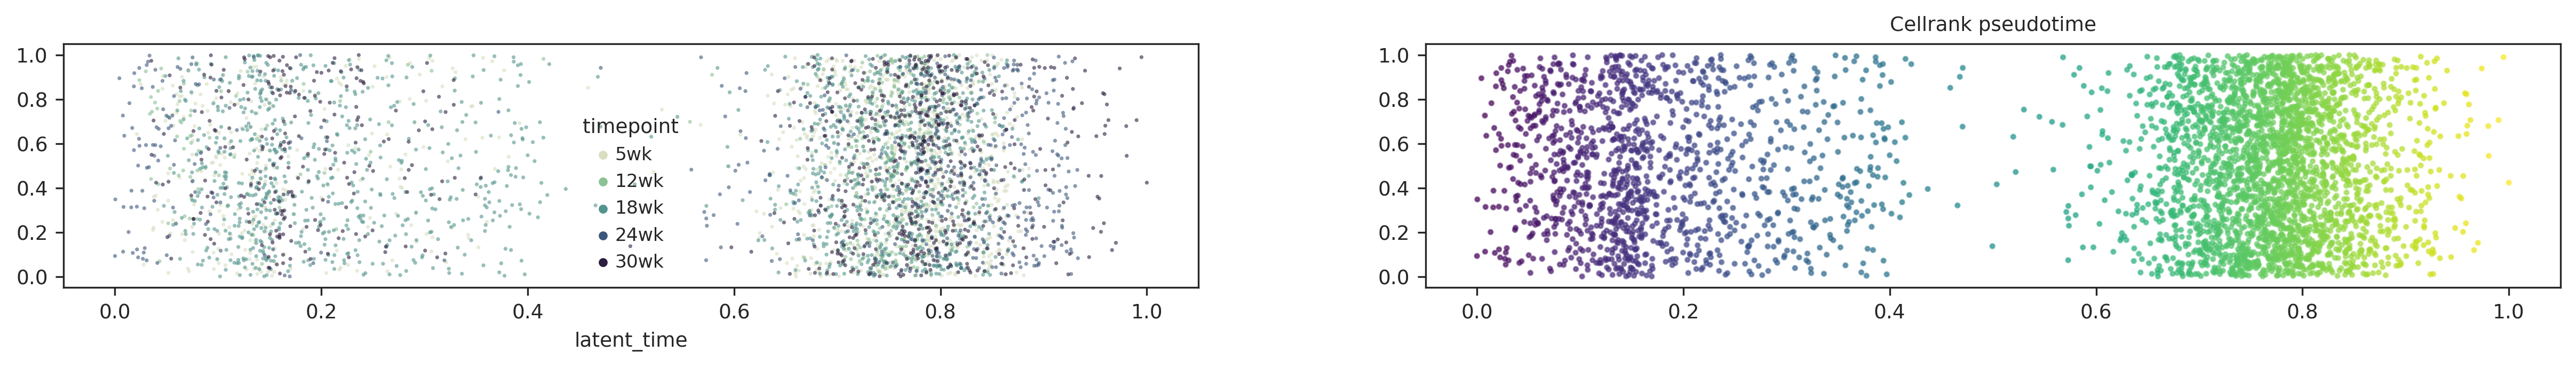

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(20, 2))
sns.scatterplot(x=adata.obs['latent_time'], y=rand_hgt, hue=adata.obs['timepoint'], ax=ax[0], linewidth=0., alpha=0.6, s=3, palette=cmap_wt)
ax[1].scatter(adata.obs['latent_time'], rand_hgt, c=adata.obs['latent_time'].to_numpy(), cmap='viridis', s=3, alpha=0.6)
ax[1].set_title('Cellrank pseudotime')

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.99536264 0.98665553 0.9851587  0.97871685 0.9642767
     0.9633852  0.94649196 0.9433442  0.9407743  0.9398882  0.9341175
     0.9296344  0.9258474  0.9211793 ]
    finished (0:00:00)
computing Diffusion Pseudotime using n_dcs=10
    finished (0:00:00)


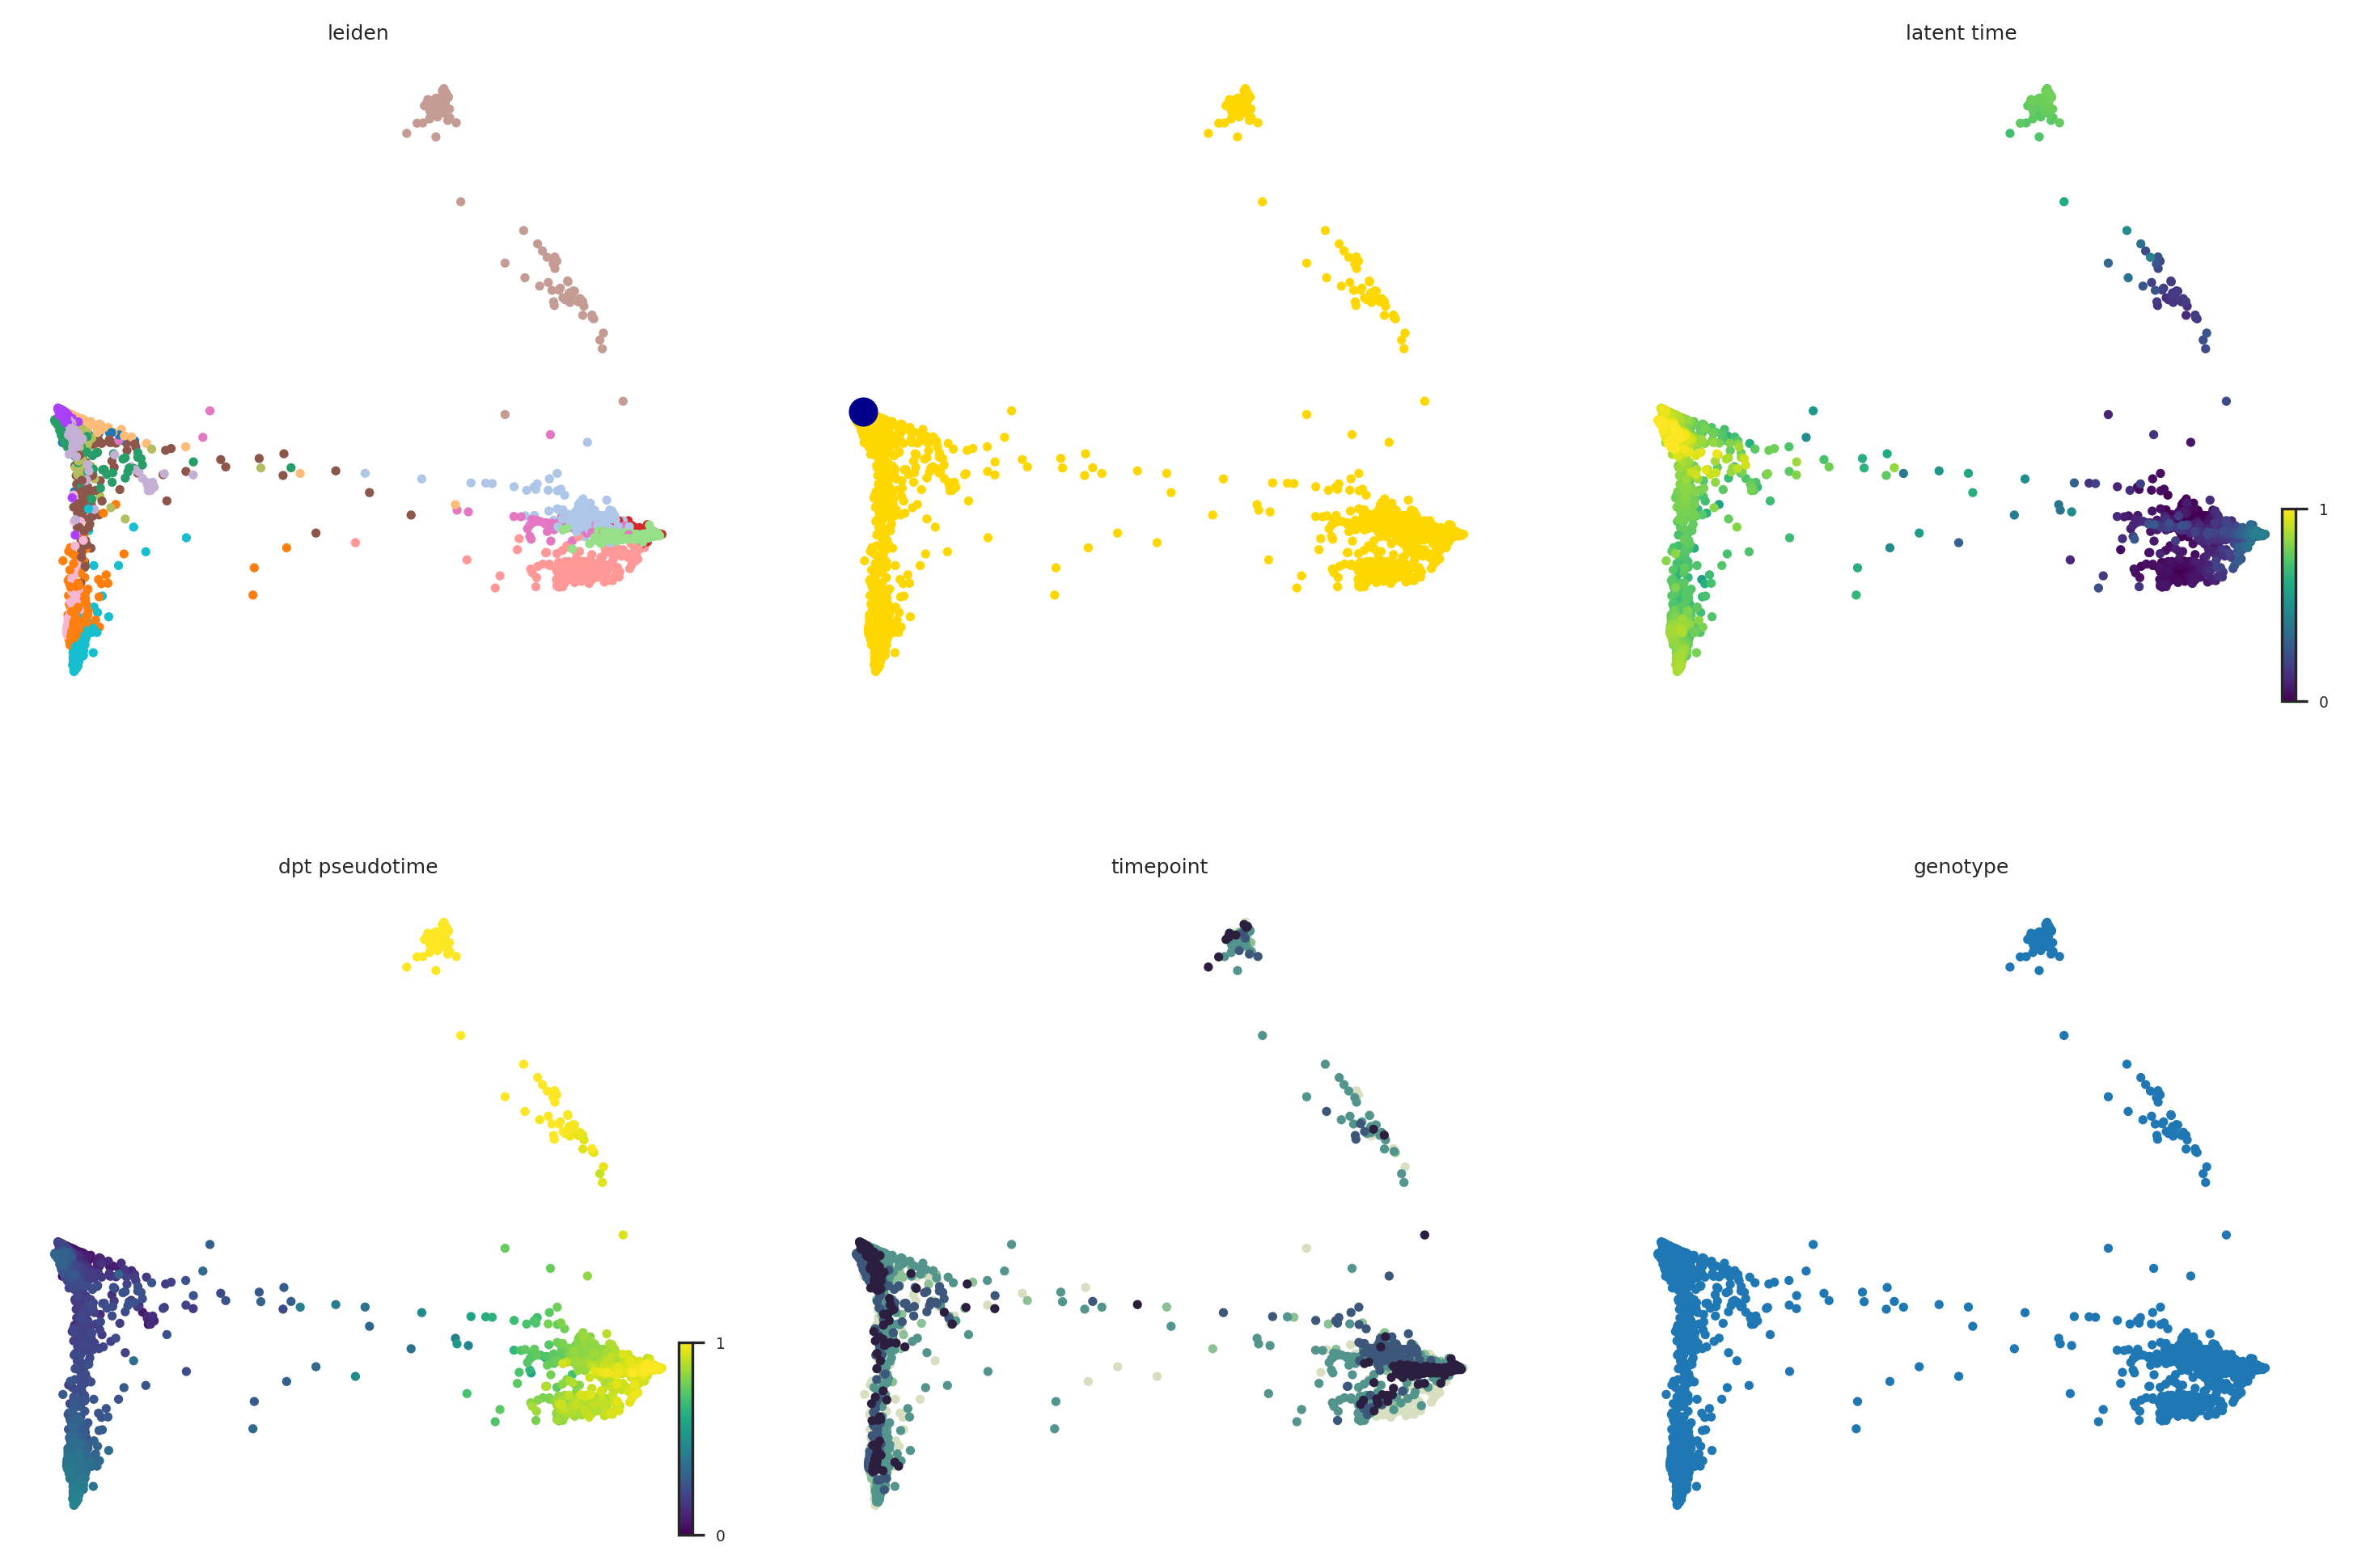

In [35]:
root_idx = np.random.choice(np.where(adata.obs['initial_states']  == '5' )[0])
adata.uns['iroot'] = root_idx
sc.tl.dpt(adata)

scv.pl.scatter(adata, color=['leiden', root_idx, 'latent_time', 'dpt_pseudotime', 'timepoint', 'genotype'],
               fontsize=6, basis='phate', ncols=3,  
               cmap='viridis', perc=[2, 98], colorbar=True, rescale_color=[0, 1])

In [99]:
adata.obs

batch genotype timepoint  n_genes_by_counts  \
AAACCCACAGAGGAAA     7202       WT       5wk               2132   
AAACGAATCGTGCTCT     7202       WT       5wk               2117   
AAACGAATCGTGTCAA     7202       WT       5wk               2034   
AAAGAACCAGTGACCC     7202       WT       5wk               2385   
AAAGGATAGGGCAGTT     7202       WT       5wk               2437   
...                   ...      ...       ...                ...   
TTGTTCATCCCGTGTT    58242     SCA1      30wk               1871   
TTTACGTGTCCTACAA-1  58242     SCA1      30wk               1991   
TTTACTGCAGTCTCTC    58242     SCA1      30wk               3424   
TTTGGTTTCCACTAGA    58242     SCA1      30wk               1514   
TTTGTTGTCGTTCTGC    58242     SCA1      30wk               3574   

                    log1p_n_genes_by_counts  total_counts  log1p_total_counts  \
AAACCCACAGAGGAAA                   7.665285        4031.0            8.302018   
AAACGAATCGTGCTCT                   7.658228        4047.0            8.305978   
AAACGAATCGTGTCAA                   7.618251        3522.0            8.167068   
AAAGAACCAGTGACCC                   7.777374        5346.0            8.584291   
AAAGGATAGGGCAGTT                   7.798933        4615.0            8.437284   
...                                     ...           ...                 ...   
TTGTTCATCCCGTGTT                   7.534763        3112.0            8.043343   
TTTACGTGTCCTACAA-1                 7.596894        3599.0            8.188689   
TTTACTGCAGTCTCTC                   8.138857        6890.0            8.837972   
TTTGGTTTCCACTAGA                   7.323171        2535.0            7.838343   
TTTGTTGTCGTTCTGC                   8.181720        8508.0            9.048880   

                    pct_counts_in_top_50_genes  pct_counts_in_top_100_genes  \
AAACCCACAGAGGAAA                     25.378318                    31.729099   
AAACGAATCGTGCTCT                     24.141339                    30.590561   
AAACGAATCGTGTCAA                     21.862578                    27.938671   
AAAGAACCAGTGACCC                     29.517396                    36.700337   
AAAGGATAGGGCAGTT                     22.405200                    28.602384   
...                                        ...                          ...   
TTGTTCATCCCGTGTT                     23.971722                    30.012853   
TTTACGTGTCCTACAA-1                   24.006669                    30.425118   
TTTACTGCAGTCTCTC                     17.474601                    22.902758   
TTTGGTTTCCACTAGA                     24.418146                    31.597633   
TTTGTTGTCGTTCTGC                     20.862717                    27.785614   

                    pct_counts_in_top_200_genes  ...  \
AAACCCACAGAGGAAA                      40.287770  ...   
AAACGAATCGTGCTCT                      39.362491  ...   
AAACGAATCGTGTCAA                      36.910846  ...   
AAAGAACCAGTGACCC                      45.155256  ...   
AAAGGATAGGGCAGTT                      37.248104  ...   
...                                         ...  ...   
TTGTTCATCCCGTGTT                      38.367609  ...   
TTTACGTGTCCTACAA-1                    39.538761  ...   
TTTACTGCAGTCTCTC                      30.711176  ...   
TTTGGTTTCCACTAGA                      41.775148  ...   
TTTGTTGTCGTTCTGC                      36.013164  ...   

                    velocity_self_transition  leiden  terminal_states  \
AAACCCACAGAGGAAA                    0.171722       1              NaN   
AAACGAATCGTGCTCT                    0.245354       0              NaN   
AAACGAATCGTGTCAA                    0.179791       8              NaN   
AAAGAACCAGTGACCC                    0.215270       1              NaN   
AAAGGATAGGGCAGTT                    0.013836       0              NaN   
...                                      ...     ...              ...   
TTGTTCATCCCGTGTT                    0.084038      20              NaN   
TTTACGTGTCCTACAA-1                  